In [1]:
import netCDF4
import itertools

from tqdm import tqdm

Nx = 512
Ny = 512
Nz = 601
Na = 5
Ns = 25

In [1]:
mu_id = ['10', '8', '6', '4', '2']

T = np.zeros((Na, Nz, Ny * Nx))
t = np.zeros((Na, Nz, Ny * Nx))

T_ssd = np.zeros((Na, Nz, Ns))
t_ssd = np.zeros((Na, Nz, Ns))

T_300 = np.zeros((Na, Nz, Ns))
t_300 = np.zeros((Na, Nz, Ns))

for i in range(Na):
    
    T[i, :, :] = np.array(netCDF4.Dataset('./ssd/222809/' + mu_id[i] + '/T_onTau.222809.nc.1')['T']).reshape(Nz, Ny * Nx)
    t[i, :, :] = np.array(netCDF4.Dataset('./ssd/222809/' + mu_id[i] + '/taugrid.222809.nc.1')['tau']).reshape(Nz, Ny * Nx)
    
    sample = np.random.choice(Nx * Ny, Ns, replace = False)
    
    T_ssd[i, :, :] = T[i, :, sample].T
    t_ssd[i, :, :] = t[i, :, sample].T

    T[i, :, :] = np.array(netCDF4.Dataset('./300G/627321/' + mu_id[i] + '/T_onTau.627321.nc.1')['T']).reshape(Nz, Ny * Nx)
    t[i, :, :] = np.array(netCDF4.Dataset('./300G/627321/' + mu_id[i] + '/taugrid.627321.nc.1')['tau']).reshape(Nz, Ny * Nx)
    
    sample = np.random.choice(Nx * Ny, Ns, replace = False)
    
    T_300[i, :, :] = T[i, :, sample].T
    t_300[i, :, :] = t[i, :, sample].T
    
    for k in range(Ns):
        
        for j in range(Nz - 1):
            
            delta = np.abs(np.log10(t_ssd[i, j, k]) - np.log10(t_ssd[i, j + 1, k]))
        
            if np.abs(delta - 0.0001) < 1e-6: T_ssd[i, j, k] = np.nan
                
            delta = np.abs(np.log10(t_300[i, j, k]) - np.log10(t_300[i, j + 1, k]))

            if np.abs(delta - 0.0001) < 1e-6: T_300[i, j, k] = np.nan

np.savez('intro_img_2', t_ssd = t_ssd, t_300 = t_300, T_ssd = T_ssd, T_300 = T_300)

ModuleNotFoundError: No module named 'netCDF4'

In [2]:
t_ssd = np.load('intro_img_2.npz')['t_ssd']
t_300 = np.load('intro_img_2.npz')['t_300']
T_ssd = np.load('intro_img_2.npz')['T_ssd']
T_300 = np.load('intro_img_2.npz')['T_300']

In [4]:
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.5)

plt.rcParams.update({'font.size': 8})
plt.rcParams["font.family"] = 'Times New Roman'

mus = ['1.0', '0.8', '0.6', '0.4', '0.2']

fig = plt.figure(dpi = 300)

fig.set_size_inches(10, 11.25, forward = True)

fig.tight_layout()

gs = gridspec.GridSpec(5, 3, width_ratios = [1, 1, 1], hspace = 0.03, wspace = 0.05)

for i in range(5):

    ssd = plt.subplot(gs[i, 0])
    mag = plt.subplot(gs[i, 1])
        
    com = plt.subplot(gs[i, 2])
    
    ssd.set_xscale('log')
    
    for k in range(Ns):
        
        ssd.plot(t_ssd[i, :, k], T_ssd[i, :, k], color = 'gray')

plt.savefig('intro_img_2.pdf', bbox_inches = 'tight')

plt.close('all')

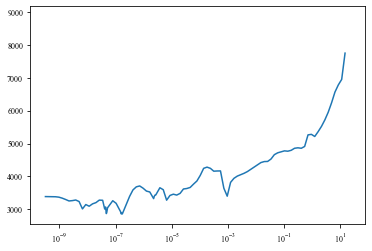

In [9]:
plt.plot(t_ssd[4, :, 0], T_ssd[4, :, 0])

plt.xscale('log')

plt.show()

In [77]:
np.abs(np.log10(t[4, 599, 0]) - np.log10(t[4, 598, 0]) - 0.0001)

1.4195090650072784e-10

In [13]:
len(t_300[2, :, 11])

601